In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import cobra
import scipy

# Yeast

In [2]:
exometabolites_folder = Path("../../data/yeast/")
organism = 'yeast'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
gDW_per_OD = np.mean([0.644, 0.848])

In [4]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'yeast')

## Remove outliers

In [5]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,0.790,0.174697
1,0.807,0.174697
2,1.170,0.098995
3,1.950,0.084853
4,3.000,0.127279
5,4.675,0.077782
6,6.805,0.049497
7,7.010,0.197990
8,6.750,0.608112


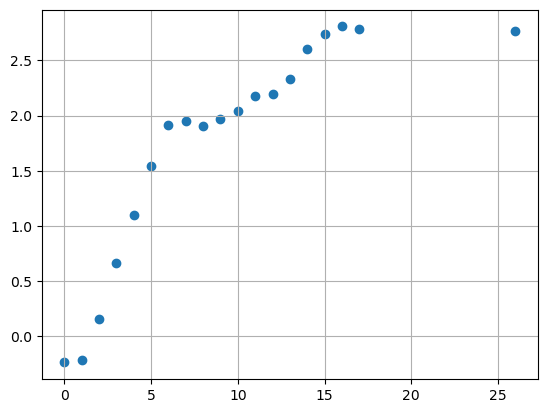

In [6]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate
Answer = 8 mmol/gDW/h

In [79]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [80]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [81]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

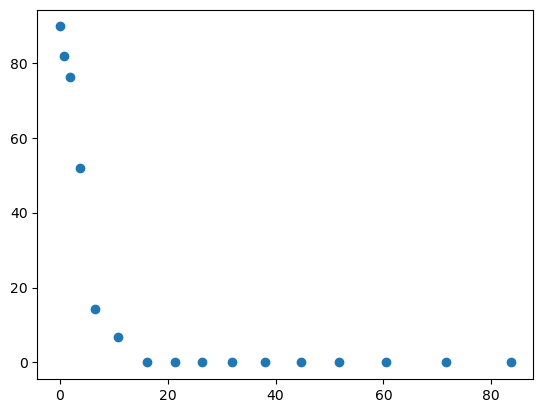

In [82]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [83]:
df_OD.loc[1:6, 'Cum OD gDW']

Time
1     0.000000
2     0.737421
3     1.849334
4     3.678899
5     6.480751
6    10.734505
Name: Cum OD gDW, dtype: float64

In [84]:
np.polyfit(df_OD.loc[1:6, 'Cum OD gDW'], df_glucose.loc[1:6, 'Glucose mM'], 1)

array([-8.41111574, 86.33002799])

## Mapping

In [85]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Yeast metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [86]:
x = np.cumsum(df_OD['OD mean'])*gDW_per_OD

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


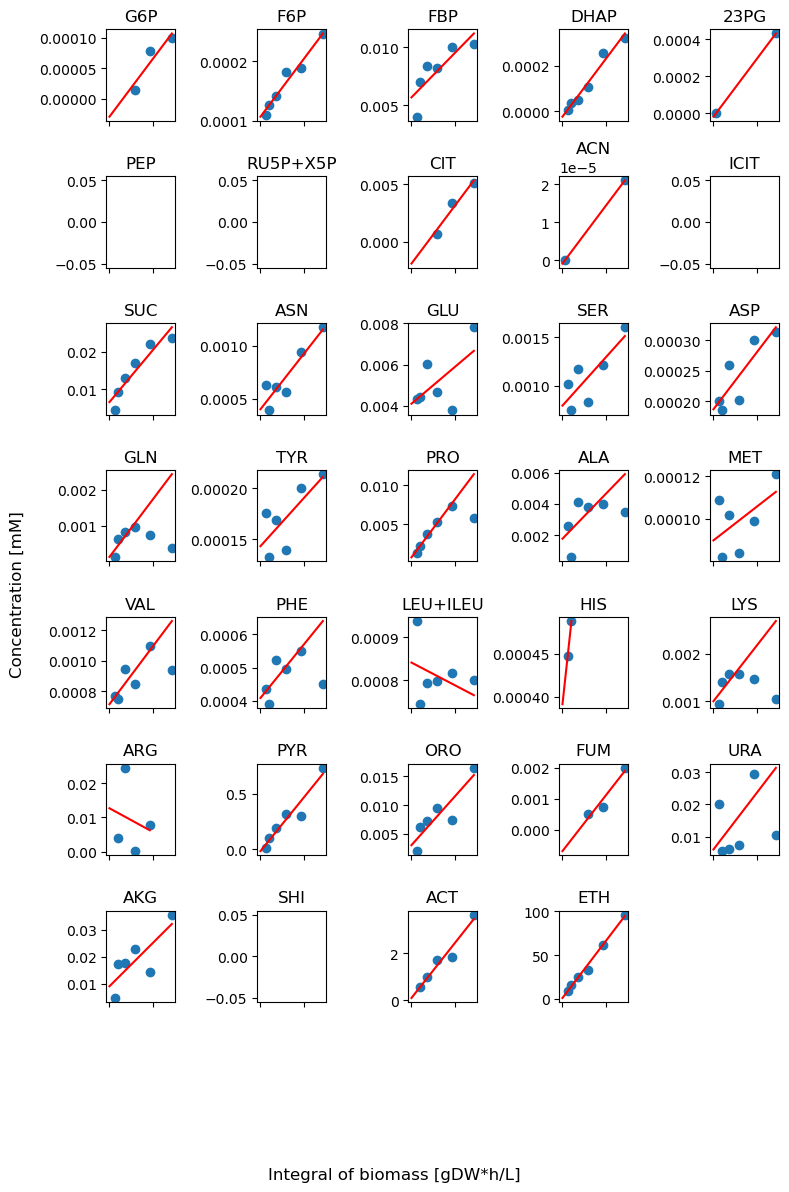

In [88]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 7
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
    # print(c)
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (5 in rate_conc.index) and (6 in rate_conc.index):
        if rate_conc[6] < rate_conc[5]:
            selection[6] = False
            if rate_conc[5] < rate_conc[4]:
                selection[5] = False
                
    if len(conc[nan_idx&time_idx]) >1:
        fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                                   conc[nan_idx&time_idx&selection],
                                                   full_output=True)
        rate_dict[c] = fit[0]
    else:
        rate_dict[c] = np.nan

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.show()


In [89]:
rate_dict

{'G6P': 9.505568649051493e-06,
 'F6P': 9.776019161656112e-06,
 'FBP': 0.0003849188745723047,
 'DHAP': 2.5388744950441975e-05,
 '23PG': 3.13874063821448e-05,
 'PEP': nan,
 'RU5P+X5P': nan,
 'CIT': 0.0005070427999871657,
 'ACN': 1.5293167842808376e-06,
 'ICIT': nan,
 'SUC': 0.0014004072376727955,
 'ASN': 5.240153757831557e-05,
 'GLU': 0.000179635296962267,
 'SER': 5.0027519304184284e-05,
 'ASP': 9.373626013763747e-06,
 'GLN': 0.00016012174645632632,
 'TYR': 4.767734782025762e-06,
 'PRO': 0.000751229710159897,
 'ALA': 0.0002903059079740295,
 'MET': 1.5894993555322214e-06,
 'VAL': 3.783146801141533e-05,
 'PHE': 1.6179910033258154e-05,
 'LEU+ILEU': -5.2565022909659005e-06,
 'HIS': 4.697417566050269e-05,
 'LYS': 0.00011741546162016314,
 'ARG': -0.0006934404797695197,
 'PYR': 0.04856333656350536,
 'ORO': 0.0008533902343530742,
 'FUM': 0.00018030281748730893,
 'URA': 0.0017656684027500594,
 'AKG': 0.0016078137831463623,
 'SHI': nan,
 'ACT': 0.23391714567973793,
 'ETH': 6.553645389120347}

# Get model

## Functions

In [90]:


def print_summary_r(model, solution):
    # Print uptake
    for r_id in model.get_exchange_reactions():
        flux = solution.values[r_id]
        r = model.reactions[r_id]
        if  flux >1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
        elif flux < -1e-3:
            print(r_id, r.name, flux, r.lb, r.ub)
    #print("## Demands ##")
    #for r in model.demands:
    #    print(r.id, solution[r.id])

    print("Growth: ", solution.values['R_r_2111'])
    print("Prot pool exchange: ", solution.values['R_prot_pool_exchange'])

In [20]:
model_ez = reframed.load_cbmodel('../../models/yeast/ecYeastGEM_batch_8_3_4_no_rev_ex.xml')
model_ez.solver = 'gurobi'

In [65]:
solution = reframed.FBA(model_ez, constraints={'R_r_1714':(-8.4, 0)})
print_summary_r(model_ez, solution)

R_r_1634 acetate exchange 3.0757547920109873 0.0 inf
R_r_1654 ammonium exchange -2.433034376645051 -inf inf
R_r_1672 carbon dioxide exchange 9.116343047175178 0.0 inf
R_r_1714 D-glucose exchange -8.4 -inf 0.0
R_r_1761 ethanol exchange 4.184084589210849 0.0 inf
R_r_1793 formate exchange 0.015220715199668732 0.0 inf
R_r_1832 H+ exchange -0.33105925084131016 -inf inf
R_r_1992 oxygen exchange -6.284051298123331 -inf 0.0
R_r_2005 phosphate exchange -0.09711569323302217 -inf inf
R_r_2020 potassium exchange -0.0012891476190274053 -inf inf
R_r_2033 pyruvate exchange 4.063716832668949 0.0 inf
R_r_2049 sodium exchange -0.0014098942279721206 -inf inf
R_r_2060 sulphate exchange -0.03251056278015401 -inf inf
R_r_2100 water exchange 15.399401351907864 -inf inf
R_r_2111 growth 0.3551370851315166 0.0 inf
R_prot_pool_exchange prot_pool_exchange 0.103720024310123 0.0 0.103720024310123
Growth:  0.3551370851315166
Prot pool exchange:  0.103720024310123


# Mapping

In [15]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)


In [75]:
measured_metabolites = []
for value in met_abrv_to_id.values():
    if not isinstance(value, str):
        continue
    bigg_ids = value.split(', ')
    for bigg_id in bigg_ids:
        m_id = f'M_{bigg_id}__91__c__93__'
        if m_id in model_ez.metabolites:
            measured_metabolites.append(m_id)

# Turnover

In [115]:
solution = reframed.pFBA(model_ez, constraints={'R_r_1714':(-7.4, 0)})
turnover = solution.get_metabolites_turnover(model_ez)

# Shadow prices

In [121]:
if len(measured_metabolites):
    shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714':(-3, 0)},
                                                        metabolites = measured_metabolites)

In [122]:
shadow_prices

{'M_s_0568__91__c__93__': -0.09450732406007245,
 'M_s_0557__91__c__93__': -0.0945073240600558,
 'M_s_0555__91__c__93__': -0.09884411389382564,
 'M_s_0629__91__c__93__': -0.049422056946824,
 'M_s_0764__91__c__93__': -0.049422056946946125,
 'M_s_0188__91__c__93__': -0.03959489118329773,
 'M_s_0260__91__c__93__': -0.03959489118345316,
 'M_s_1360__91__c__93__': -0.03959489118339765,
 'M_s_1408__91__c__93__': -0.07947890168908955,
 'M_s_0577__91__c__93__': -0.07947890168907845,
 'M_s_0581__91__c__93__': -0.07947890168910621,
 'M_s_0551__91__c__93__': -0.06445047931800119,
 'M_s_0522__91__c__93__': -0.070808213214546,
 'M_s_0516__91__c__93__': -0.0708082132145127,
 'M_s_0940__91__c__93__': -0.07080821321437392,
 'M_s_1458__91__c__93__': -0.05057564304280504,
 'M_s_1271__91__c__93__': -0.03959489118328108,
 'M_s_0991__91__c__93__': -0.07080821321443498,
 'M_s_1039__91__c__93__': -0.041618726439185405,
 'M_s_0973__91__c__93__': -0.04710910236891408,
 'M_s_1045__91__c__93__': -0.068787269151665

# Make spreadsheet

In [123]:
data = []
for abbr, rate in rate_dict.items():
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
    rate = rate/len(bigg_ids)
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}__91__c__93__'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        model_met_name = m.name.replace('[cytoplasm]','')
        data.append([bigg_id, name, model_met_name, rate, mv, turnover[m_id], Nc, mass])
df_rate = pd.DataFrame(data, columns = ['Yeast ID', 'Metabolite', 'Model metabolite name', 'Rate [mmol/gDW/h]', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]'])

In [124]:
df_rate['Species'] = 'S. cerevisiae'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [125]:
df_rate.to_csv('paczia_13_rates_yeast.csv')

In [113]:
df_rate

,Yeast ID,Metabolite,Model metabolite name,Rate [mmol/gDW/h],Metabolite value [gDW/mmol],Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Species,Carbon source,Dataset
0,s_0568,Glucose-6-phosphate,D-glucose 6-phosphate,0.000010,8.056446e-03,8.400000,6,260.135781,S. cerevisiae,Glucose,Paczia-13
1,s_0557,Fructose-6-phosphate,D-fructose 6-phosphate,0.000010,8.134678e-03,7.684598,6,258.119901,S. cerevisiae,Glucose,Paczia-13
2,s_0555,"Fructose-1,6-bisphosphate","D-fructose 1,6-bisphosphate",0.000385,1.264478e-02,0.000000,6,340.115682,S. cerevisiae,Glucose,Paczia-13
3,s_0629,Dihydroxyacetonephosphate,dihydroxyacetone phosphate,0.000025,6.536907e-03,7.453698,3,168.041961,S. cerevisiae,Glucose,Paczia-13
4,s_0188,2/3-phosphoglycerate,2-phospho-D-glyceric acid,0.000016,3.870400e-03,14.554853,3,183.033421,S. cerevisiae,Glucose,Paczia-13
5,s_0260,2/3-phosphoglycerate,3-phosphonato-D-glycerate(3-),0.000016,3.842926e-03,14.839901,3,183.033421,S. cerevisiae,Glucose,Paczia-13
6,s_1360,Phosphoenolpyruvate,phosphoenolpyruvate,NaN,4.048356e-03,14.554853,3,165.018141,S. cerevisiae,Glucose,Paczia-13
7,s_0577,Ribu-/Xylulose-5-phosphate,D-ribulose 5-phosphate,NaN,6.784829e-03,0.181093,5,228.093921,S. cerevisiae,Glucose,Paczia-13
8,s_0581,Ribu-/Xylulose-5-phosphate,D-xylulose 5-phosphate,NaN,6.941216e-03,0.059686,5,228.093921,S. cerevisiae,Glucose,Paczia-13
9,s_0522,Citrate,citrate,0.000507,1.060617e-02,0.119371,6,189.099700,S. cerevisiae,Glucose,Paczia-13
